# Unconditional image generation

In [14]:
import torch 
from datasets import load_dataset
from diffusers import DDPMPipeline, UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt
import cv2
import numpy
from skimage.color import rgb2lab, lab2rgb
import torch
from torchvision import transforms
import PIL.Image as I
from mpl_toolkits.axes_grid1 import ImageGrid
import random
from matplotlib.colors import LinearSegmentedColormap

Load test data

In [3]:
dataset = load_dataset("m1guelpf/nouns", split="train")
dataset = dataset.train_test_split(0.2)
# test_dataloader = torch.utils.data.DataLoader(dataset["test"], batch_size=8)

In [4]:
rgb = dataset["test"][0:4]["image"]
lab = [rgb2lab(image) for image in rgb]

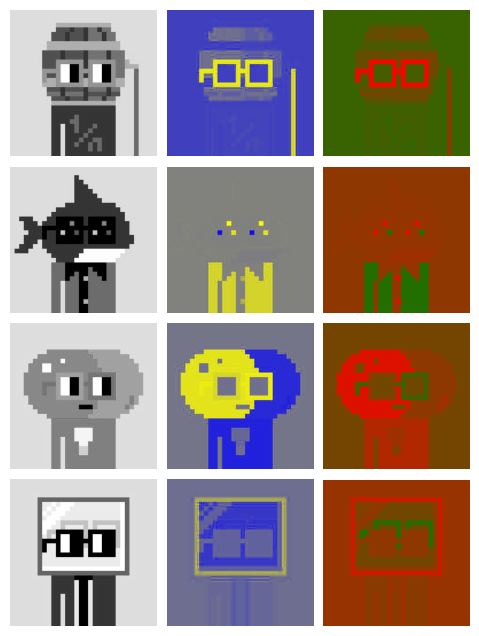

In [15]:
#

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

cmap_green_to_red = LinearSegmentedColormap.from_list(
    'green_to_red', [(0, 'green'), (1, 'red')], N=255
)

cmap_blue_to_yellow = LinearSegmentedColormap.from_list(
    'blue_to_yellow', [(0, 'blue'), (1, 'yellow')], N=255
)
lab_list = []
c = ["gray",cmap_blue_to_yellow ,cmap_green_to_red]
j = 0
for l in lab:
    for i in range(3):
        lab_list.append(l[..., i])

i = 0 
for ax, im in zip(grid, numpy.array(lab_list)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap=c[(i)%3])
    ax.axis("off")
    i += 1

plt.savefig("lab channels.jpg")

In [64]:
# test_images = random.sample(dataset["test"]["image"], 4)
# test_images = dataset["test"][:5]["image"]

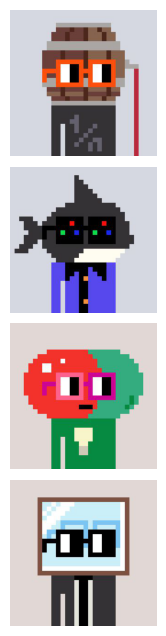

In [18]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, numpy.array(rgb)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")

plt.savefig("RGB.JPG")

Prepare pipeline

In [7]:
unet_dir = "../m1guelpf_nouns/unet/"
sche_dir = "../m1guelpf_nouns/scheduler/"
device = "cuda"
unet = UNet2DModel.from_pretrained(unet_dir)
scheduler = DDPMScheduler.from_pretrained(sche_dir)
pipeline = DDPMPipeline(unet=unet, scheduler=scheduler).to(device)

Prepare data

In [88]:
test_images = rgb
tfms = transforms.Compose(
        [
            transforms.Resize((128, 128)),
            transforms.ColorJitter(
                brightness=0.1, contrast=0.9, saturation=(1.0, 2.0), hue=0
            ),
            transforms.ToTensor(),
        ]
    )   

test_images = [tfms(image.convert("L").convert("RGB")) for image in test_images]
test_images = torch.stack(test_images)


In [89]:

# def generate():
images = pipeline(condition_images=test_images.to(device),
                 output_type="numpy",
                num_inference_steps=1000,
                generator=torch.manual_seed(13)
                 ).images


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.05it/s]


In [79]:
images.shape

(4, 128, 128, 3)

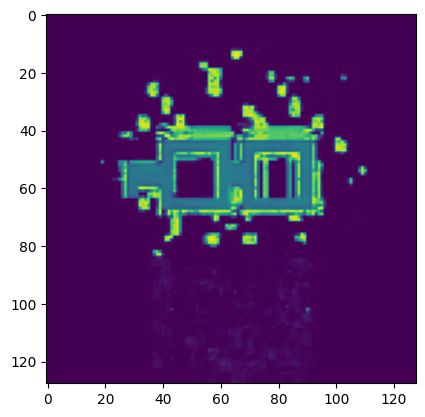

In [91]:

plt.imshow(images[1, ..., 1])

In [113]:
# rgb_predict = [cv2.cvtColor(image, cv2.COLOR_Lab2BGR) for image in images]
rgb_predict = lab2rgb(images)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


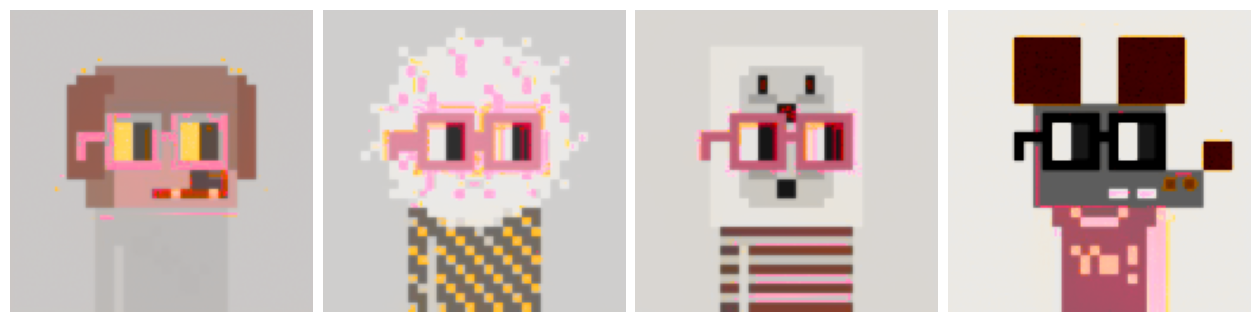

In [115]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, numpy.array(rgb_predict)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im*128)
    ax.axis("off")

plt.savefig("RGB_predict.JPG")